In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [11]:
simData = pd.read_csv("data/earth_orbit_simulation.csv")
simData.head()


,time,x,y,vx,vy
0,0,1.496000e+11,0.000000e+00,0.000000,29783.000000
1,21600,1.495972e+11,6.433128e+08,-128.124172,29783.000000
2,43200,1.495917e+11,1.286614e+09,-256.249530,29782.449023
3,64800,1.495834e+11,1.929891e+09,-384.373707,29781.347048
4,86400,1.495723e+11,2.573132e+09,-512.494335,29779.694065


In [12]:
# Create features and target variables
# Features: time, x, y
# Time is the independent variable, and x and y are the dependent variables
time = simData[['time']]
x_target = simData['x']
y_target = simData['y']

In [13]:
scaler_time = MinMaxScaler()
scalerx = MinMaxScaler()
scalery = MinMaxScaler()

# Fit and transform
time_scaled = scaler_time.fit_transform(time)
x_scaled = scalerx.fit_transform(x_target.values.reshape(-1, 1))
y_scaled = scalery.fit_transform(y_target.values.reshape(-1, 1))


In [ ]:
# Train-test split
# Split the data into training and testing sets
# split the data into training and testing sets for x
# 80% for training and 20% for testing
X_train, X_test, y_train_x, y_test_x = train_test_split(time_scaled, x_scaled, test_size=0.2, random_state=42)

# 42 for the meaning of life, the universe, and everything
# Split the time and Y position into training and testing sets (again 80/20)
_, _, y_train_y, y_test_y = train_test_split(time_scaled, y_scaled, test_size=0.2, random_state=42)

In [18]:
# Reshape the input (time) to 3D shape for LSTM: (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [21]:
# Define the LSTM model for X
model_x = Sequential()
# Used tanh activation function for LSTM layer, better for time series data
model_x.add(LSTM(50, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
# Output layer: predict x-coordinate
model_x.add(Dense(1))
model_x.compile(optimizer='adam', loss='mse')

# Define the LSTM model for Y
model_y = Sequential()
model_y.add(LSTM(50, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
# Output layer: predict y-coordinate
model_y.add(Dense(1))
model_y.compile(optimizer='adam', loss='mse')


In [23]:
# Train the X model
history_x = model_x.fit(X_train, y_train_x, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Train the Y model
history_y = model_y.fit(X_train, y_train_y, epochs=100, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3680 - val_loss: 0.2443
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2504 - val_loss: 0.1609
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1614 - val_loss: 0.1304
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1414 - val_loss: 0.1272
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1339 - val_loss: 0.1267
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1297 - val_loss: 0.1260
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1280 - val_loss: 0.1254
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1299 - val_loss: 0.1250
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1329 - val_loss: 0.1247
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1257 - val_loss: 0.1242
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1249 - val_loss: 0.1242
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1

In [24]:
# Predict X and Y coordinates
y_pred_x_lstm = model_x.predict(X_test)
y_pred_y_lstm = model_y.predict(X_test)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [ ]:
# Inverse transform the scaled predictions
y_pred_x_lstm = scalerx.inverse_transform(y_pred_x_lstm)
y_pred_y_lstm = scalery.inverse_transform(y_pred_y_lstm)

# Inverse transform the true values too (for accurate comparison)
y_test_x_real = scalerx.inverse_transform(y_test_x)
y_test_y_real = scalery.inverse_transform(y_test_y)

# Unscale the time values for plotting

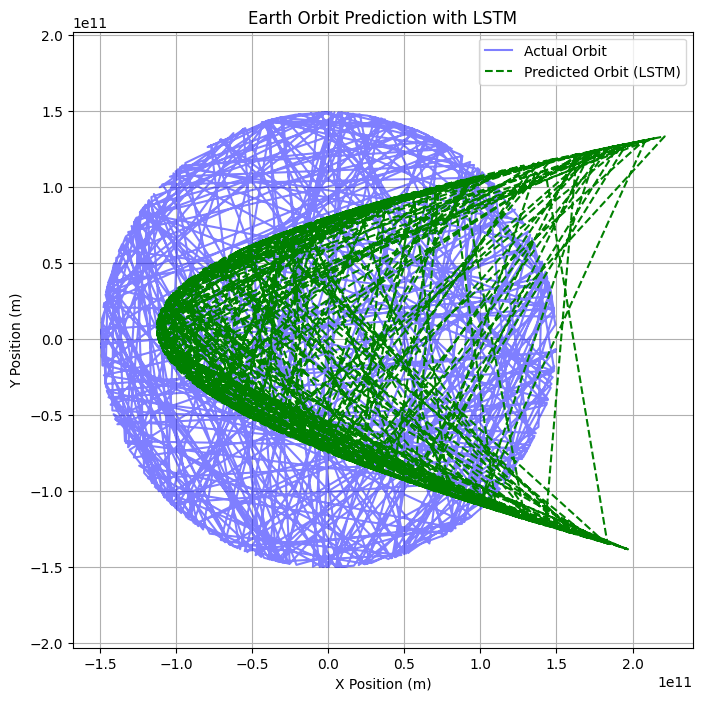

In [27]:
# Plot the actual vs predicted orbit
plt.figure(figsize=(8,8))
plt.plot(y_test_x_real, y_test_y_real, label='Actual Orbit', color='blue', alpha=0.5)
plt.plot(y_pred_x_lstm, y_pred_y_lstm, label='Predicted Orbit (LSTM)', color='green', linestyle='--')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Earth Orbit Prediction with LSTM')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()


In [28]:
# Evaluate R² and MSE
print("LSTM R² X:", r2_score(y_test_x_real, y_pred_x_lstm))
print("LSTM MSE X:", mean_squared_error(y_test_x_real, y_pred_x_lstm))

print("LSTM R² Y:", r2_score(y_test_y_real, y_pred_y_lstm))
print("LSTM MSE Y:", mean_squared_error(y_test_y_real, y_pred_y_lstm))


LSTM R² X: 0.9330329463610386
LSTM MSE X: 7.113005376051336e+20
LSTM R² Y: 0.6234699640826911
LSTM MSE Y: 4.401279700803088e+21
